In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from SHDataset import SHDataset
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from metrics import *

In [3]:
dataset = SHDataset(noise=True, dataset_dir='./dataset/', noise_config=2)

Loading map: Wien: : 4it [00:00, 2339.92it/s]


In [4]:
G1,T1,G2,T2 = dataset.read_snapshots(0)

In [5]:
bbox = (52.355, 52.365, 4.860, 4.900)
G1,T1,G2,T2 = filter_bbox_snapshots(G1,T1,G2,T2,bbox)

### Visualizing Maps + Trajectories & Changes

#### Visualizing Maps + Trajectories

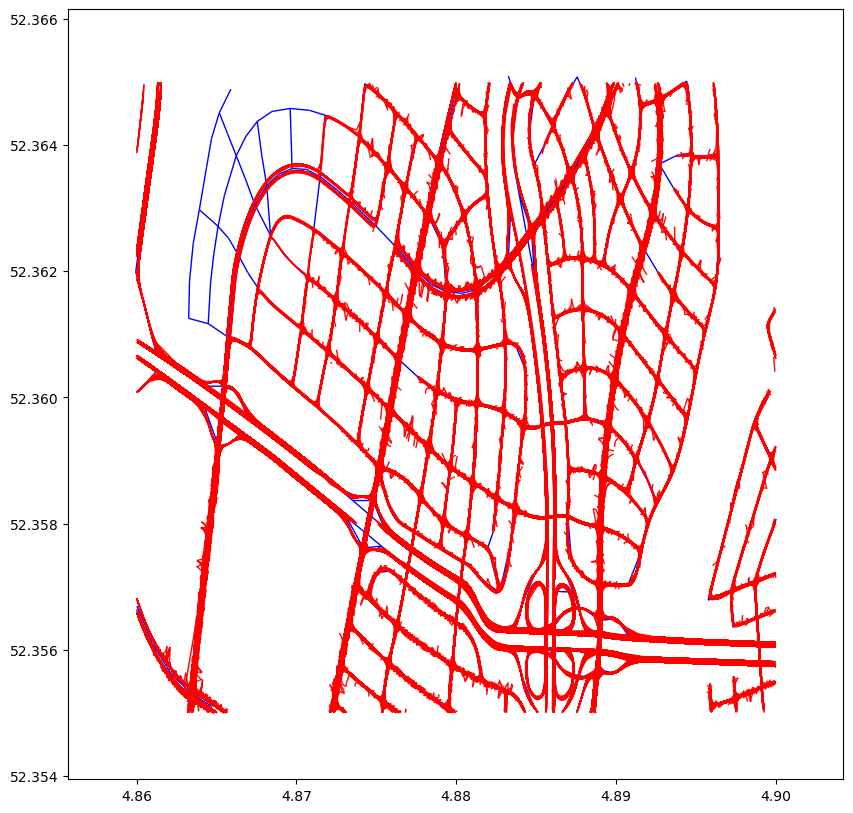

In [24]:
plot_graph(snapshot_to_nxgraph(G1,T2['T']), figsize=(10,10),savename='test')

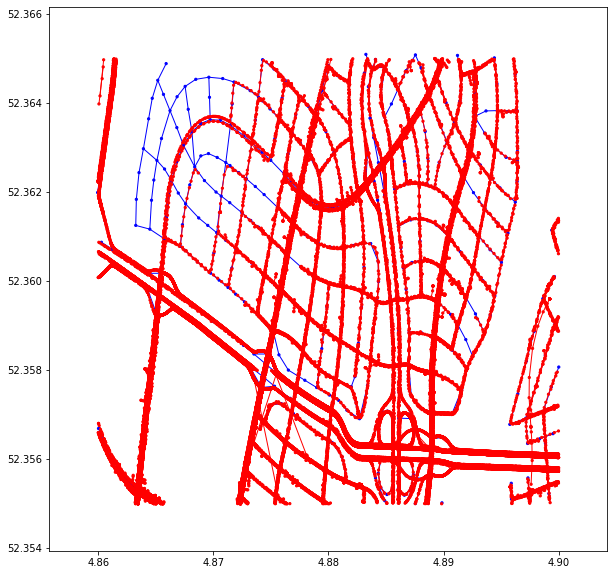

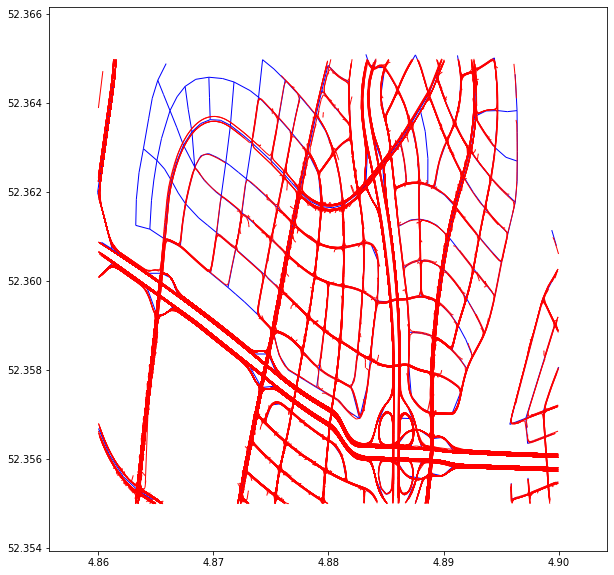

In [124]:
plot_graph(snapshot_to_nxgraph(G1,T2['T']), figsize=(10,10))

#### Visualizing Changes

In [31]:
G1_d, G12_d, G2_d, G21_d = compare_snapshots(G1,G2)

In [32]:
plot_graph(G12_d, figsize=(15,15), show_labels=True, show_nodes=True, fontsize=8, savename='test', show_img=False)

### Change Detectors

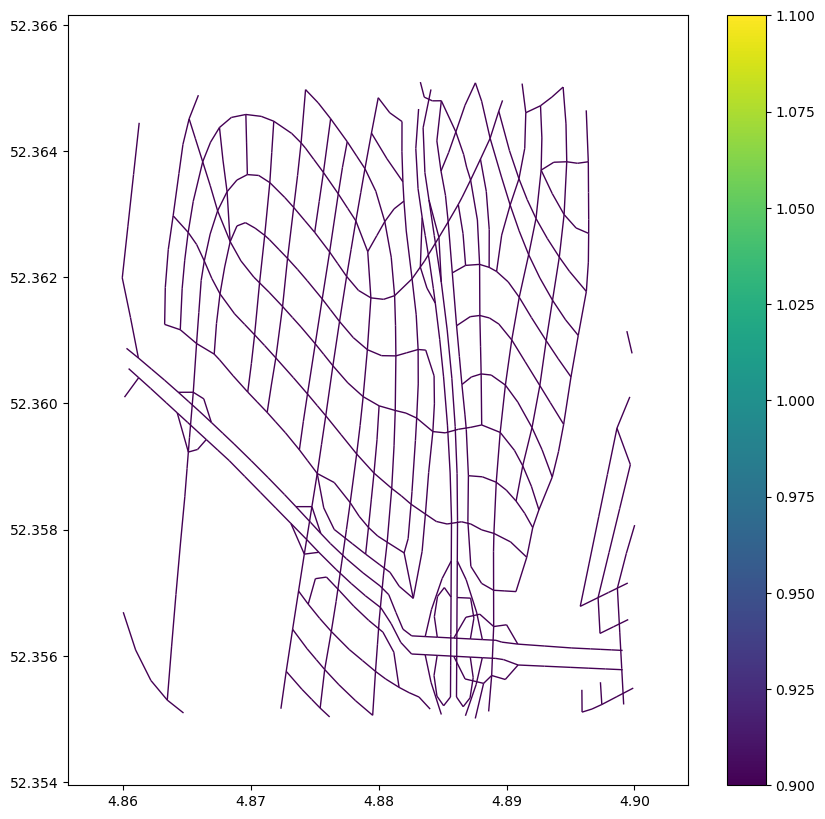

In [6]:
from models.always_true import AlwaysTrueDetector

alwaystrue_det = AlwaysTrueDetector(G1)
G2_pred_true = alwaystrue_det.forward(T2)
plot_graph(G2_pred_true, use_weights=True, figsize=(10,10))

In [7]:
from metrics import *
from sklearn.metrics import f1_score

scores_true = predicted_labels(G2_pred_true)
p_true, r_true, ts_true, pr_auc_true = PRCurve(groundtruth_labels(G1, G2), scores_true, norm=False, savename='test')
        

print(f'F score: {fscore(groundtruth_labels(G1,G2), scores_true)}')

F score: 0.03829160530191458


In [15]:
gt_labels = groundtruth_labels(G1,G2) 
num_deleted =sum(list(gt_labels.values()))
total = len(gt_labels)

always_false = {k : 0 for k in gt_labels}
random_d = {k : np.random.choice(2) for k in gt_labels}


predictions_rb = {k: int(scores_rb[k] == 0) for k in gt_labels}
predictions_rb2 = {k: int(scores_rb2[k] == 0) for k in gt_labels}
predictions_hmm = {k: int(scores_hmm[k] == 0) for k in gt_labels}
predictions_hmm2 = {k: int(scores_hmm2[k] == 0) for k in gt_labels}

print('Always true', fscore(gt_labels, scores_true))
print('Always False', fscore(gt_labels, always_false))
print('Random', fscore(gt_labels, random_d))
print('rule based', fscore(gt_labels, predictions_rb))
print('HMM', fscore(gt_labels, predictions_hmm))
print('HMM2', fscore(gt_labels, predictions_hmm2))
print('rule based 2: ', fscore(gt_labels, predictions_rb2))

# predictions_hmm
# scores_hmm

print((len([v for v in scores_hmm.values() if 1!=0])))

for key, lbl in gt_labels.items():
    if lbl==1:
        print(f'Edge {key} has score: {scores_rb2[key]}')
for key, lbl in gt_labels.items():
    if lbl==1:
        print(f'Edge {key} has score: {scores_rb[key]}')

# nx.get_edge_attributes(G2_pred_hmm, "weight")


NameError: name 'scores_rb' is not defined

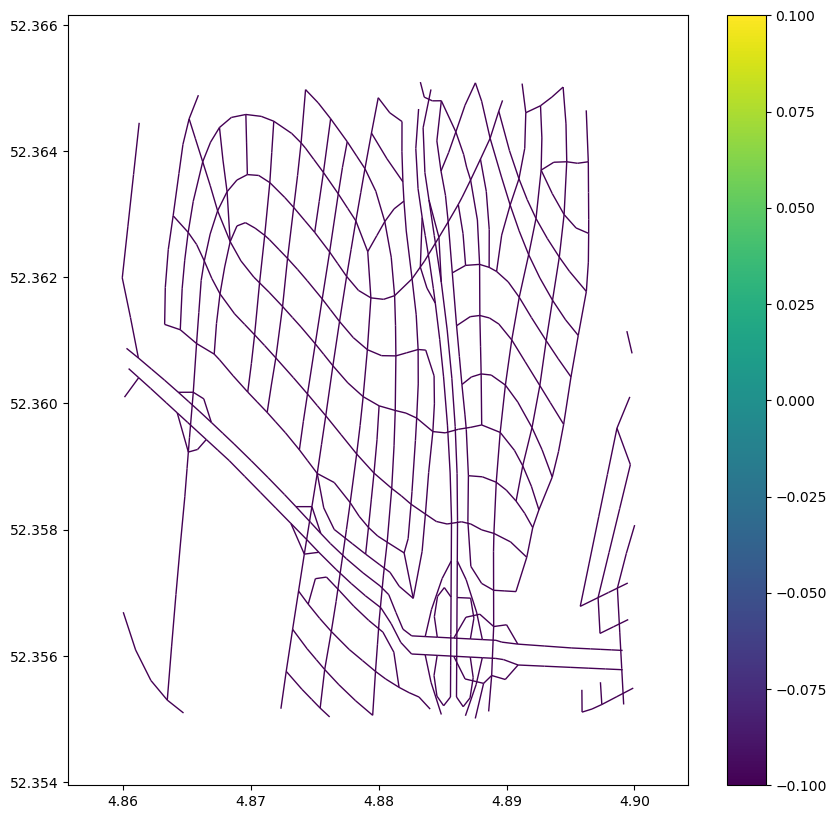

In [16]:
from models.always_false import AlwaysFalseDetector

alwaysfalse_det = AlwaysFalseDetector(G1)
G2_pred_false = alwaysfalse_det.forward(T2)
plot_graph(G2_pred_false, use_weights=True, figsize=(10,10))

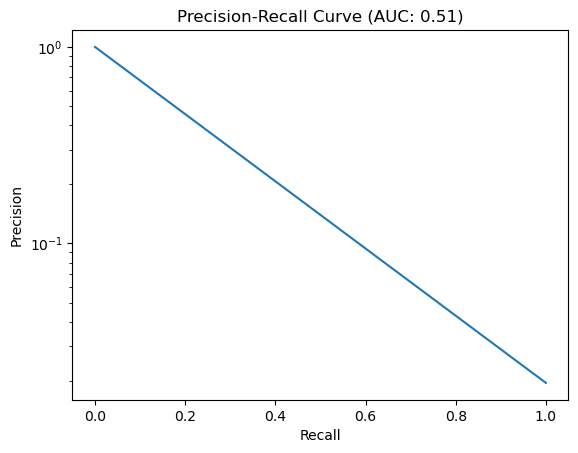

In [17]:
scores_false = predicted_labels(G2_pred_false)
p_false, r_false, ts_false, pr_auc_false = PRCurve(groundtruth_labels(G1, G2), scores_false)

#### Random Change Detector

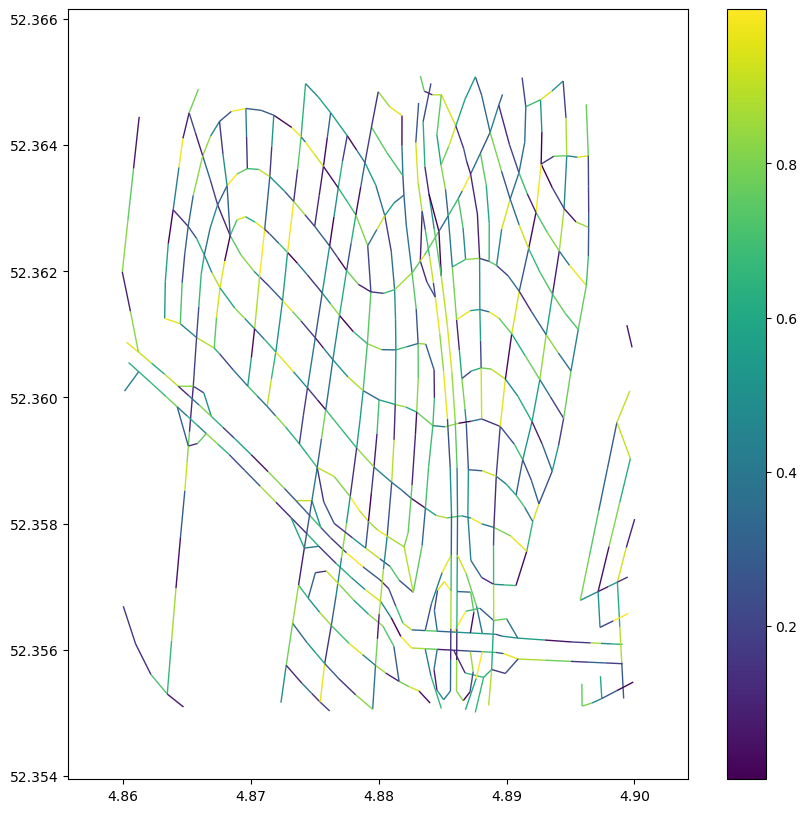

In [18]:
from models.random import RandomDetector

random_det = RandomDetector(G1)
G2_pred_rand = random_det.forward(T2)
plot_graph(G2_pred_rand, use_weights=True, figsize=(10,10))

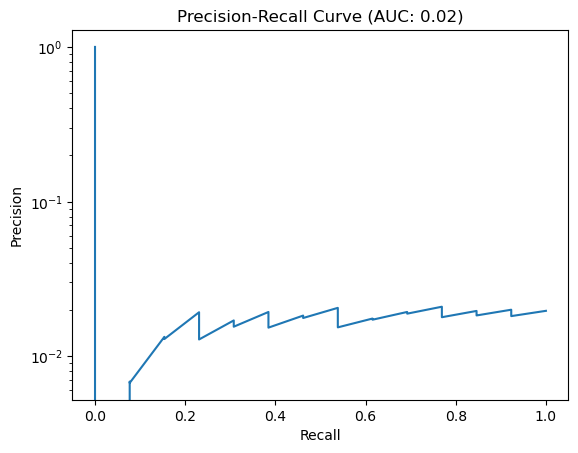

In [20]:
scores_rand = predicted_labels(G2_pred_rand)
p_rand, r_rand, ts_rand, pr_auc_rand = PRCurve(groundtruth_labels(G1, G2), scores_rand)

#### Rule-based Change Detector

In [21]:
from models.rulebased import RulebasedDetector

rule_det = RulebasedDetector(G1)
G2_pred_rb = rule_det.forward(T2['T'])

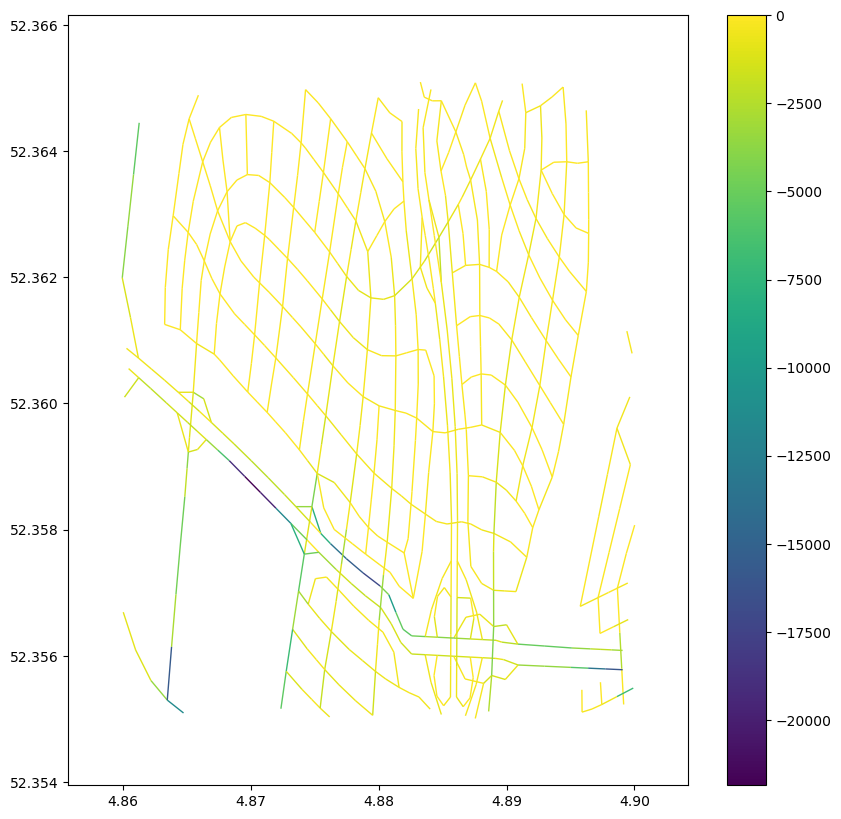

In [22]:
plot_graph(G2_pred_rb, use_weights=True, figsize=(10,10))

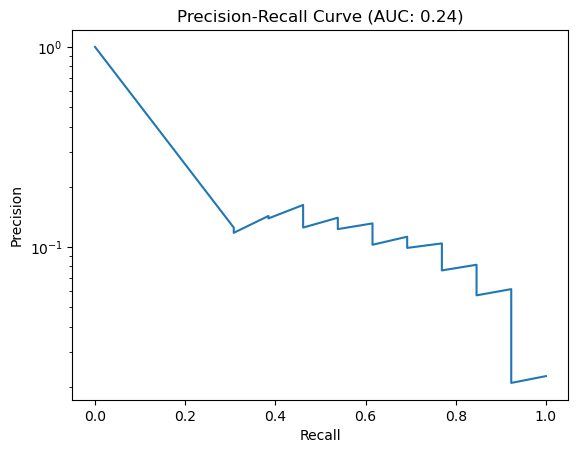

In [23]:
scores_rb = predicted_labels(G2_pred_rb)
p_rb, r_rb, ts_rb, pr_auc_rb = PRCurve(groundtruth_labels(G1, G2), scores_rb)

### HMM Based Change Detector

In [55]:
from models.hmm import HMMChangeDetector

hmm_det = HMMChangeDetector(G1, use_latlon=False)
G2_pred_hmm = hmm_det.forward(T2['T'])

Map matching trajectory: 2038/2039: : 2039it [44:15,  1.30s/it]

No matches for 0/2039 trajectories


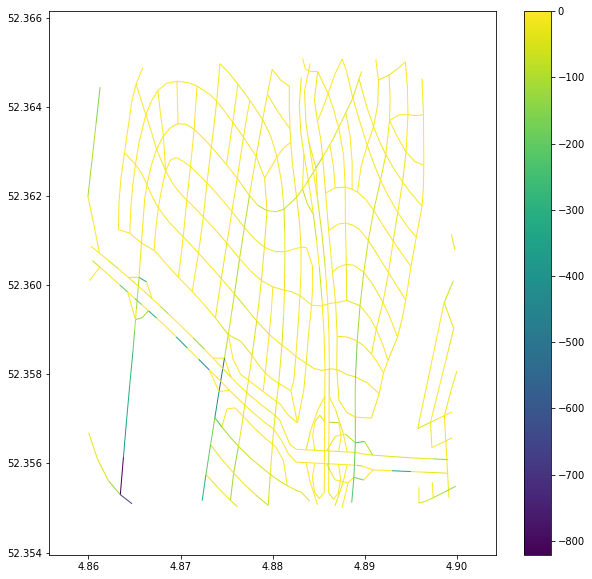

In [56]:
plot_graph(G2_pred_hmm, use_weights=True, figsize=(10,10))

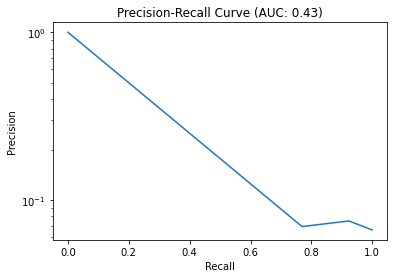

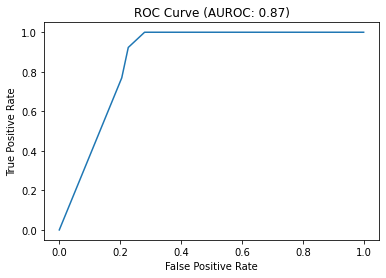

In [57]:
scores_hmm = predicted_labels(G2_pred_hmm)
p_hmm, r_hmm, ts_hmm, pr_auc_hmm = PRCurve(groundtruth_labels(G1, G2), scores_hmm)

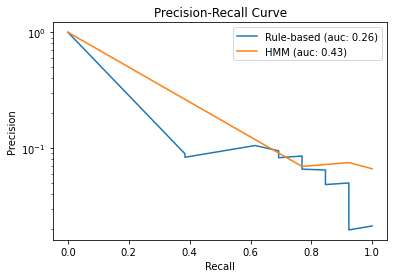

In [63]:
# PRCombine(ps=[p_rand, p_rb, p_hmm], rs=[r_rand, r_rb, r_hmm], aucs=[pr_auc_rand, pr_auc_rb, pr_auc_hmm],
#           labels=['Random', 'Rule-based', 'HMM'])
PRCombine(ps=[p_rb, p_hmm], rs=[r_rb, r_hmm], aucs=[pr_auc_rb, pr_auc_hmm],
          labels=['Rule-based', 'HMM'])

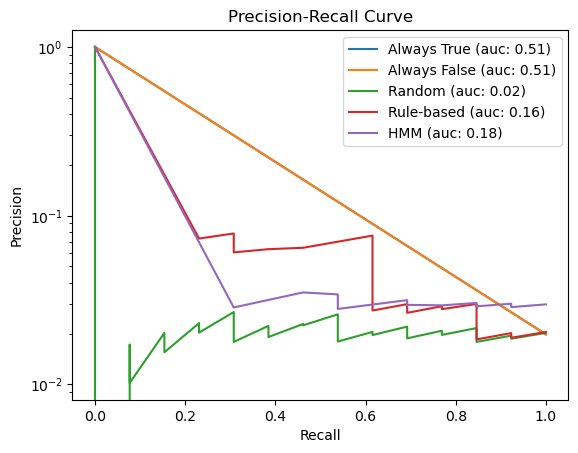

In [23]:
PRCombine(ps=[p_true, p_false, p_rand, p_rb, p_hmm], rs=[r_true, r_false, r_rand, r_rb, r_hmm],
          aucs=[pr_auc_true, pr_auc_false, pr_auc_rand, pr_auc_rb, pr_auc_hmm], 
          labels=['Always True', 'Always False', 'Random', 'Rule-based', 'HMM'])

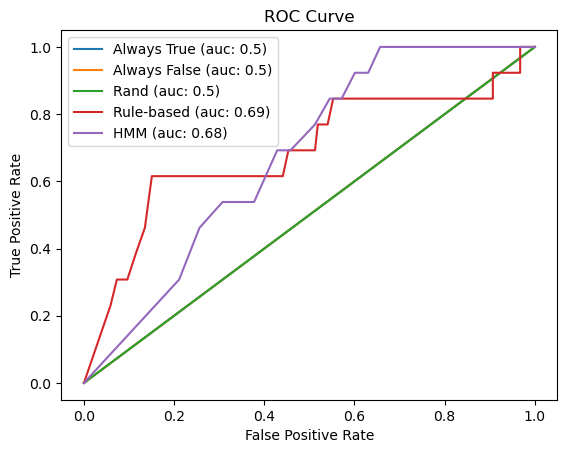

In [24]:
ROCCombine([fpr_true, fpr_false, fpr_rand, fpr_rb, fpr_hmm], 
           [tpr_true, tpr_false, tpr_rand, tpr_rb, tpr_hmm], 
           [auroc_true, auroc_false, auroc_rand, auroc_rb, auroc_hmm], 
           ['Always True', 'Always False', 'Rand', 'Rule-based', 'HMM'])

In [29]:
def evaluate_predictions(G2_pred, targets):
    num_edges = len([edge for edge in G2_pred.edges])
    
    edge_weights = nx.get_edge_attributes(G2_pred, 'weight')
    
    # Get number of roads with no matches
    nomatch_edges = [edge for edge, weight in edge_weights.items() if weight == 0]
    num_nomatch_roads = len(nomatch_edges)
    
    # Get number of roads that are actually removed
    removed_edges = [edge for edge, weight in targets.items() if weight == 1]
    num_removed_roads = len(removed_edges)
    
    print(f'# of roads with no matches: {num_nomatch_roads}/{num_edges} ({round((num_nomatch_roads/num_edges)*100,2)}%)')
    print(f'# of roads actually removed: {num_removed_roads}/{num_edges} ({round((num_removed_roads/num_edges)*100,2)}%)')
    
    # Get number of removed roads that were matched with trajectories
    removed_edges_weights = [edge_weights[edge] for edge in removed_edges]
    num_removed_edges_w_weights = len([weight for weight in removed_edges_weights if weight != 0])
    print(f'# of removed roads with non-zero weight: {num_removed_edges_w_weights}/{num_edges} ({round((num_removed_edges_w_weights/num_edges)*100,2)}%)')
    
    # Get average weight of removed roads
    avg_removed_road_weight = np.mean(removed_edges_weights)
    print(f'Average edge weight of removed segments: {avg_removed_road_weight}')
    
    # Get average weight of non removed roads
    nonremoved_edges_weights = [weight for edge, weight in edge_weights.items() if edge not in removed_edges]
    avg_nonremoved_road_weight = np.mean(nonremoved_edges_weights)
    print(f'Average edge weight of remaining segments: {avg_nonremoved_road_weight}')
    
    # Get number of non removed roads that weren't matched
    nonremoved_nomatch_edges = [weight for edge, weight in edge_weights.items() if edge not in removed_edges and weight == 0]
    num_nonremoved_nomatch_edges = len(nonremoved_nomatch_edges)
    print(f"# of non removed roads that weren't matched: {num_nonremoved_nomatch_edges}/{num_edges} ({round((num_nonremoved_nomatch_edges/num_edges)*100,2)}%)")
    
    
    
evaluate_predictions(G2_pred_hmm, groundtruth_labels(G1,G2))

# of roads with no matches: 140/657 (21.31%)
# of roads actually removed: 13/657 (1.98%)
# of removed roads with non-zero weight: 7/657 (1.07%)
Average edge weight of removed segments: -1.3846153846153846
Average edge weight of remaining segments: -20.922360248447205
# of non removed roads that weren't matched: 134/657 (20.4%)


In [33]:
evaluate_predictions(G2_pred_rb, groundtruth_labels(G1,G2))

# of roads with no matches: 41/657 (6.24%)
# of roads actually removed: 13/657 (1.98%)
# of removed roads with non-zero weight: 10/657 (1.52%)
Average edge weight of removed segments: -28.76923076923077
Average edge weight of remaining segments: -81.8944099378882
# of non removed roads that weren't matched: 38/657 (5.78%)


In [34]:
import os
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import Image

def save_maps(G1, G2, T2, G2_pred, figsize=(10,10)):
    if not os.path.exists('./images'):
        os.mkdir('./images')
    
    G1_d, G12_d, G2_d, G21_d = compare_snapshots(G1,G2)
    plot_graph(G12_d, show_img=False, figsize=figsize)
    plt.savefig('./images/G2_changes.png')
    
    plot_graph(G2_pred, show_img=False, use_weights=True, figsize=(figsize[0]+2, figsize[1]))
    plt.savefig('./images/G2_pred.png')
    
    plot_graph(snapshot_to_nxgraph(G1,T2['T']), show_img=False, figsize=figsize)
    plt.savefig('./images/G1T2.png')
    

save_maps(G1, G2, T2, G2_pred_rb)

In [36]:
@interact
def compare_maps(file=os.listdir('./images/')):
    display(Image('./images/'+file))


interactive(children=(Dropdown(description='file', options=('G2_changes.png', 'G1T2.png', 'PR_curve_1.png', 'G…

## Taking in both T1 and T2

In [165]:
from models.hmm_2 import HMMChangeDetector2
import random

hmm_det_2 = HMMChangeDetector2(G1, use_latlon=False)
T1_sample = random.sample(T1['T'], k=400)
T2_sample = random.sample(T2['T'], k=400)
G2_pred_hmm2 = hmm_det_2.forward(T1_sample, T2_sample)
# G2_pred_hmm2 = hmm_det_2.forward(T1['T'], T2['T'])
scores_hmm2 = predicted_labels(G2_pred_hmm2)


Map matching trajectory: 399/400: : 400it [11:52,  1.78s/it]


No matches for 0/400 trajectories


Map matching trajectory: 399/400: : 400it [08:34,  1.29s/it]

No matches for 0/400 trajectories
Remaining weight: -136
Edge (76, 17348) no matches in both snapshots. setting as remaining weight
Edge (88, 16022) no matches in both snapshots. setting as remaining weight
Edge (88, 28254) no matches in both snapshots. setting as remaining weight
Edge (217, 28182) no matches in both snapshots. setting as remaining weight
Edge (401, 24673) no matches in both snapshots. setting as remaining weight
Edge (529, 20715) no matches in both snapshots. setting as remaining weight
Edge (529, 19014) no matches in both snapshots. setting as remaining weight
Edge (554, 22673) no matches in both snapshots. setting as remaining weight
Edge (554, 19807) no matches in both snapshots. setting as remaining weight
Edge (599, 5937) no matches in both snapshots. setting as remaining weight
Edge (599, 29072) no matches in both snapshots. setting as remaining weight
Edge (792, 26356) no matches in both snapshots. setting as remaining weight
Edge (835, 27962) no matches in bot

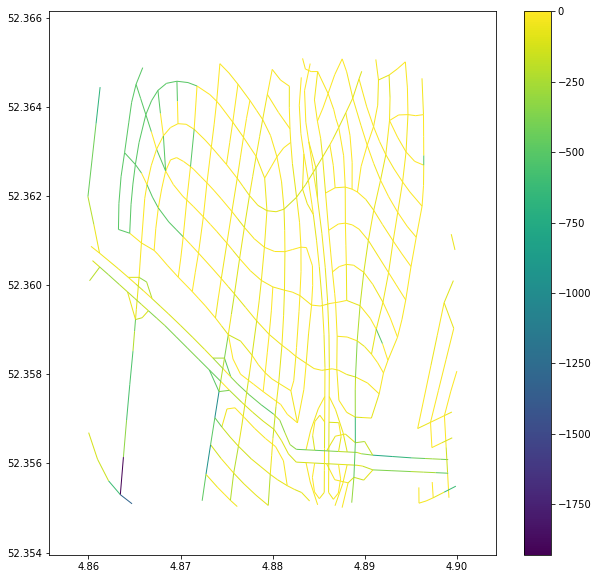

In [166]:
plot_graph(G2_pred_rb2, figsize=(10,10), use_weights=True)

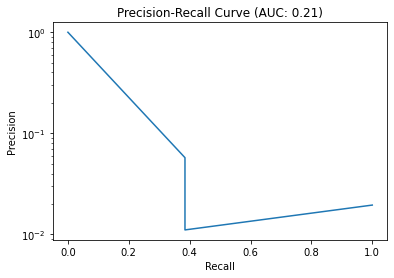

In [167]:
p_hmm2, r_hmm2, ts_hmm2, pr_auc_hmm2 = PRCurve(groundtruth_labels(G1, G2), scores_hmm2)

In [157]:
from models.rulebased_2 import RulebasedDetector2

rb_det_2 = RulebasedDetector2(G1)
G2_pred_rb2 = rb_det_2.forward(T1['T'], T2['T'])
scores_rb2 = predicted_labels(G2_pred_rb2)

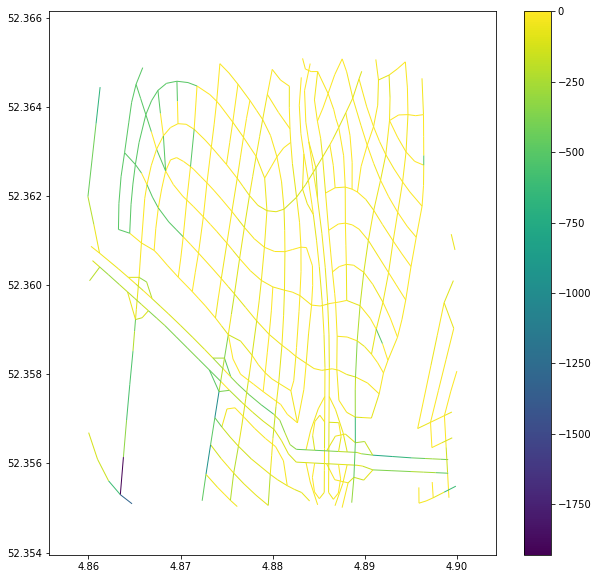

In [158]:
plot_graph(G2_pred_rb2, figsize=(10,10), use_weights=True)

In [159]:

for key, lbl in gt_labels.items():
    if lbl==1:
        print(f'Edge {key} has score: {rb_det_2.G1T1_weights[key]}')
for key, lbl in gt_labels.items():
    if lbl==1:
        print(f'Edge {key} has score: {rb_det_2.G1T2_weights[key]}')
for key, lbl in gt_labels.items():
    if lbl==1:
        print(f'Edge {key} has score: {scores_rb2[key]}')

Edge (1197, 15028) has score: -17
Edge (1585, 22777) has score: 0
Edge (6981, 19014) has score: -12
Edge (7506, 13890) has score: -33
Edge (8354, 12687) has score: -35
Edge (12687, 29944) has score: -22
Edge (12825, 31892) has score: -174
Edge (15461, 21637) has score: -74
Edge (15538, 17072) has score: -500
Edge (16052, 22494) has score: -1
Edge (19244, 28619) has score: -38
Edge (20926, 28254) has score: 0
Edge (21570, 22126) has score: 0
Edge (1197, 15028) has score: -9
Edge (1585, 22777) has score: 0
Edge (6981, 19014) has score: -2
Edge (7506, 13890) has score: -3
Edge (8354, 12687) has score: -2
Edge (12687, 29944) has score: -2
Edge (12825, 31892) has score: -5
Edge (15461, 21637) has score: -14
Edge (15538, 17072) has score: -268
Edge (16052, 22494) has score: 0
Edge (19244, 28619) has score: 0
Edge (20926, 28254) has score: 0
Edge (21570, 22126) has score: 0
Edge (1197, 15028) has score: -9
Edge (1585, 22777) has score: -500
Edge (6981, 19014) has score: -2
Edge (7506, 13890) 

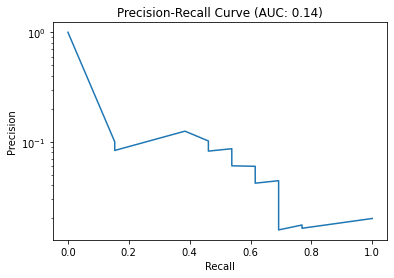

In [160]:
p_rb2, r_rb2, ts_rb2, pr_auc_rb2 = PRCurve(groundtruth_labels(G1, G2), scores_rb2)

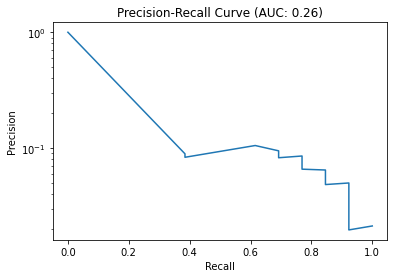

(array([0.0212766 , 0.01967213, 0.01970443, 0.01973684, 0.01976936,
        0.01980198, 0.01983471, 0.01986755, 0.0199005 , 0.01993355,
        0.02      , 0.02003339, 0.02006689, 0.0201005 , 0.02016807,
        0.02023609, 0.02027027, 0.02030457, 0.02033898, 0.02037351,
        0.02040816, 0.02044293, 0.02051282, 0.02054795, 0.02058319,
        0.02061856, 0.02065404, 0.02068966, 0.02072539, 0.02076125,
        0.02079723, 0.02083333, 0.02090592, 0.02094241, 0.02101576,
        0.02108963, 0.02112676, 0.02116402, 0.02120141, 0.02123894,
        0.0212766 , 0.02131439, 0.02135231, 0.02139037, 0.02142857,
        0.02150538, 0.02158273, 0.02166065, 0.02169982, 0.02173913,
        0.02177858, 0.02181818, 0.02189781, 0.02197802, 0.02201835,
        0.02205882, 0.02218115, 0.02234637, 0.02238806, 0.02242991,
        0.02247191, 0.02255639, 0.02264151, 0.02268431, 0.02281369,
        0.02290076, 0.02294455, 0.02307692, 0.02312139, 0.02330097,
        0.0234375 , 0.02357564, 0.02362205, 0.02

In [161]:
PRCurve(groundtruth_labels(G1, G2), scores_rb)

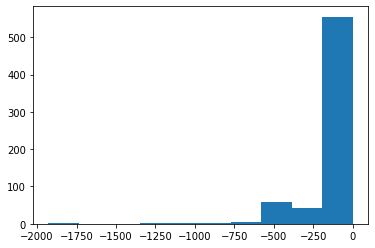

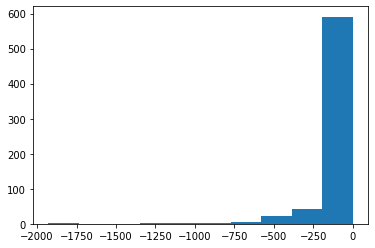

In [162]:
plt.hist(scores_rb2.values())
plt.show()
plt.hist(scores_rb.values())
plt.show()